In [131]:
import numpy as np
import pandas as pd
import heapq
import concurrent.futures
import threading
import os 
import matplotlib.pyplot as plt

In [123]:
def threading_debug():
    print(f"""
    Process ID: {os.getpid()}
    Thread ID: {threading.get_ident()}
    Thread Name: {threading.current_thread().name}
    Is main thread: {threading.current_thread() is threading.main_thread()}
    """)

## 2.3.1

In [52]:
df_edges = pd.read_csv("edges.tsv", sep="\t")
df_nodes = pd.read_csv("nodes.tsv", sep="\t")
print(df_edges.head())
print(df_nodes.head())

          u           v       length            name
0  12885866    12885923    18.992015      Hlíðartorg
1  12885866  1573411414   653.666145  Reykjanesbraut
2  12885876  1660480490    35.437064      Flatahraun
3  12885876    12885952    16.131272         FH-Torg
4  12885922  2978379988  2587.067864  Reykjanesbraut
      osmid          x          y  primary
0  12885866 -21.937473  64.067271    False
1  12885876 -21.939951  64.076157     True
2  12885922 -22.087890  64.031977    False
3  12885923 -21.937852  64.067260    False
4  12885924 -21.938078  64.067047     True


## 2.3.2

In [70]:
# Input: 
#   -node: 
#   -edges: pandas dataframe of edges
#
# Returns: numpy array of the neighbors of node and distance
def get_neighbors(node_id, edges):
    neighbors = edges.query("u == {0}".format(node_id))
    return neighbors.to_numpy()


In [146]:
# Input: 
#   -start: id of starting node
#   -nodes: 
#   -edges: 
#
# Returns: 
def dijkstra(start, nodes=df_nodes, edges=df_edges):
    threading_debug()

    dist = dict.fromkeys(nodes['osmid'], float("infinity"))
    prev_edge = dict.fromkeys(nodes['osmid'], None)
    dist[start] = 0

    heap = [(0, start)]

    while heap:
        current_dist, u = heapq.heappop(heap)
        if current_dist > dist[u]:
            continue

        neighbors = get_neighbors(u, edges)
        for neighbor in neighbors:
            _, neighbor_id, neighbor_dist, _ = neighbor

            new_dist = current_dist + neighbor_dist
            if new_dist < dist[neighbor_id]:
                dist[neighbor_id] = new_dist
                prev_edge[neighbor_id] = neighbor
                heapq.heappush(heap, (new_dist, neighbor_id))
    return start, dist, prev_edge

In [147]:
# Input:
#   -V: Hleðslustöðvar
#
# Returns: numpy array af dictionaries {station, distances, edges}
def leit(V):
    def helper(future_item):
        future = future_item.result()
        return {
            "station": future[0],
            "distances": future[1],
            "edges": future[2]
        }

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(dijkstra, node) for node in V['osmid'].tolist()]

    results = []
    for future_item in futures:
        results.append(helper(future_item))

    return np.array(results)
             
    

## 2.3.3

In [148]:
V = df_nodes.sample(n=5)
stations = leit(V)


    Process ID: 21676
    Thread ID: 22348
    Thread Name: ThreadPoolExecutor-38_0
    Is main thread: False
    

    Process ID: 21676
    Thread ID: 36548
    Thread Name: ThreadPoolExecutor-38_1
    Is main thread: False
    

    Process ID: 21676
    Thread ID: 39020
    Thread Name: ThreadPoolExecutor-38_2
    Is main thread: False
    

    Process ID: 21676
    Thread ID: 40956
    Thread Name: ThreadPoolExecutor-38_3
    Is main thread: False
    

    Process ID: 21676
    Thread ID: 22348
    Thread Name: ThreadPoolExecutor-38_0
    Is main thread: False
    


In [ ]:
# Input: 
#   -D: listi af dicitonaries {station, distances, edges}
# 
# Returns: dictionary {node_id, closest_station_id}
def find_closest_station(D, nodes=df_nodes):
    closest = dict.fromkeys(nodes["osmid"], -1)
    for v in nodes["osmid"].tolist():
        nearest_distance = float("infinity")
        for d in D:
            current_distance = d["distances"][v]
            if  current_distance < nearest_distance:
                nearest_distance = current_distance
                closest[v] = d["station"]
    return closest

closest_stations = find_closest_station(stations)

{12885866: 8866207369, 12885876: 8866207369, 12885922: 1746767891, 12885923: 8866207369, 12885924: 8866207369, 12885930: 8866207369, 12885937: 1746767891, 12885952: 8866207369, 12885974: 8866207369, 12885979: 8866207369, 12885991: 8866207369, 12886003: 8866207369, 12886006: 8866207369, 12886026: 8866207369, 12886027: 8866207369, 13472322: 323035814, 13472516: 323035814, 13472723: 323035814, 13472744: 323035814, 13489663: 323035814, 13490026: 323035814, 13800292: 323035814, 14581636: 1746767891, 14581771: 1746767891, 14581824: 1746767891, 14581900: 1746767891, 14581950: 1746767891, 14581956: 1746767891, 14581975: 1746767891, 14581979: 1746767891, 14586467: 323035814, 14586500: 297913344, 14586684: 297913344, 14586813: 323035814, 14586932: 1746767891, 14586972: 323035814, 14586999: 1746767891, 14587063: 297913344, 14587161: 1746767891, 14705468: 1746767891, 14772868: 323035814, 14772869: 323035814, 14772872: 323035814, 14772879: 323035814, 16570604: 323035814, 16570606: 323035814, 215793

In [ ]:
def find_route(node, station, edges=df_edges, nodes=df_nodes):
    



           osmid          x          y  primary
1590   243237044 -21.900494  64.114656     True
8988  2367915921 -21.835019  64.083718    False
9126  2510772190 -21.791635  64.141631    False
4665   602729017 -21.851203  64.092026    False
8670  2144109721 -21.750873  64.184869    False
5020420193
5020420193
2306377527
5020420193
2306377527


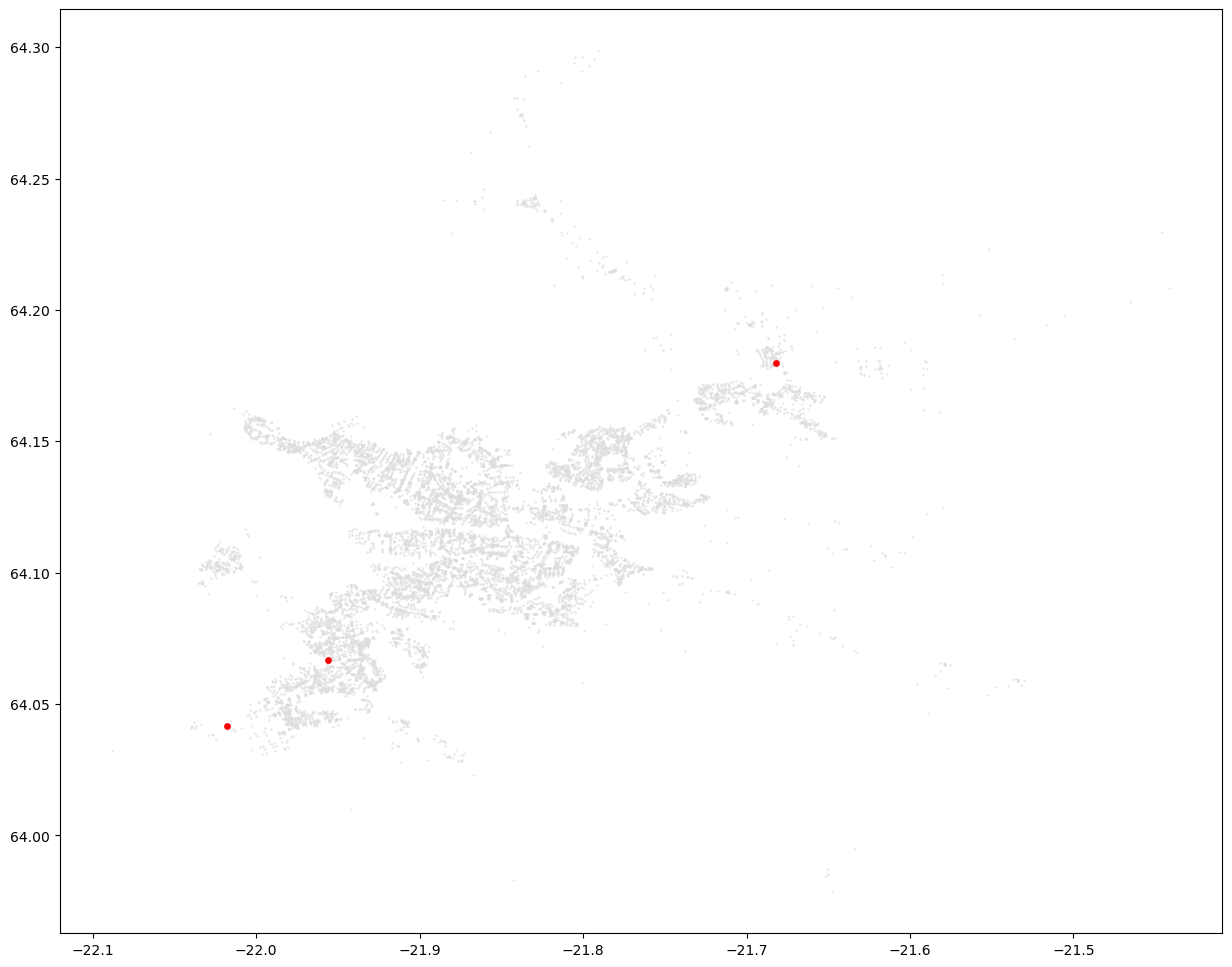

In [145]:
plt.figure(figsize=(15, 12))
plt.scatter(df_nodes['x'], df_nodes['y'], c='#dddddd', s=1, alpha=0.5)
plt.scatter(V['x'], V['y'], c='#ff0000', s=15, alpha=1)